In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from skimage.feature import hog
%matplotlib inline

In [2]:
vehicle_files = glob.glob('../vehicles/**/*.png')
vehicle_imgs = [cv2.cvtColor(cv2.imread(v), cv2.COLOR_BGR2RGB) for v in vehicle_files]
non_vehicle_files = glob.glob('../non-vehicles/**/*.png')
non_vehicle_imgs = [cv2.cvtColor(cv2.imread(v), cv2.COLOR_BGR2RGB) for v in non_vehicle_files]
num_vehicles, num_non_vehicles = len(vehicle_imgs), len(non_vehicle_imgs)
all_imgs = vehicle_imgs + non_vehicle_imgs

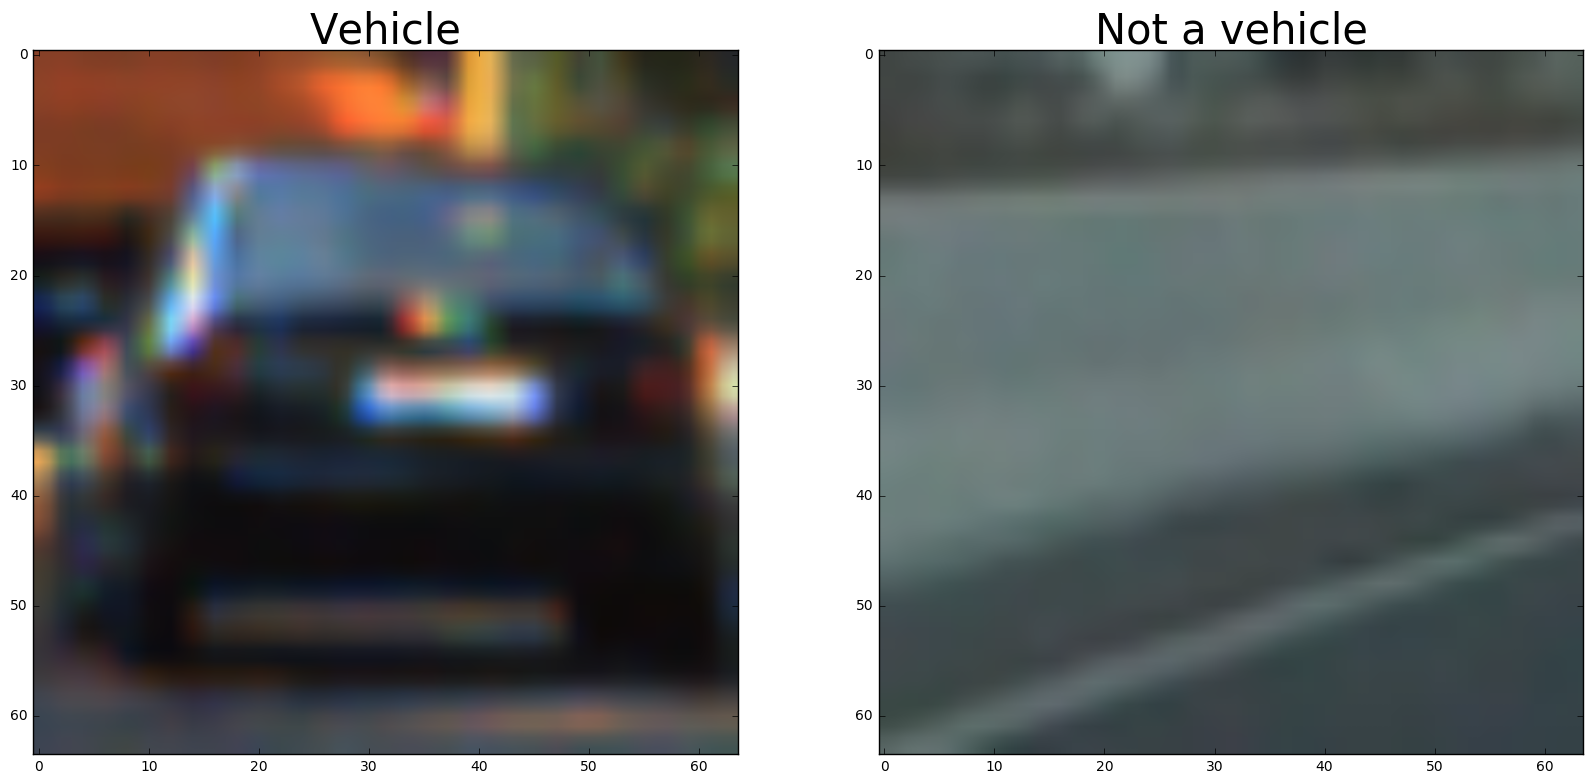

In [3]:
def show_two_images(img1, img2, title1, title2):
    cmap = None if len(img1.shape) == 3 else 'gray'
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1, cmap=cmap)
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(img2, cmap=cmap)
    ax2.set_title(title2, fontsize=30)

ind1, ind2 = np.random.randint(0, len(non_vehicle_imgs), 2)
show_two_images(vehicle_imgs[ind1], non_vehicle_imgs[ind2], 'Vehicle', 'Not a vehicle')


In [4]:
color_conversions = [cv2.COLOR_RGB2HSV, cv2.COLOR_RGB2LUV, cv2.COLOR_RGB2HLS, cv2.COLOR_RGB2YUV, cv2.COLOR_RGB2YCrCb]
def bin_spatial(img, color_conversion=None, size=(16, 16)):
    # Convert image to new color space (if specified)
    if color_conversion is not None:
        feature_image = cv2.cvtColor(img, color_conversion)
    else:
        feature_image = np.copy(img)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

In [5]:
def get_hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    hog_features = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block, transform_sqrt=False, visualise=False, feature_vector=True)
    hog_features = hog_features.ravel()
    return hog_features

In [14]:
x_list = []
for img in all_imgs:
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    bin_spatial_features = bin_spatial(img_hls, color_conversion=None)
    hog_features_h = get_hog(img_hls[:,:,0])
    hog_features_l = get_hog(img_hls[:,:,1])
    hog_features_s = get_hog(img_hls[:,:,2])
    img_features = np.concatenate((bin_spatial_features, hog_features_h, hog_features_l, hog_features_s))
    x_list.append(img_features)
print(bin_spatial_features.shape, hog_features_h.shape)

(768,) (1764,)


In [31]:
x = np.vstack(x_list).astype(np.float64)
x_scaler = StandardScaler().fit(x)
x = x_scaler.transform(x)
y = np.array([1] * num_vehicles + [0] * num_non_vehicles)
print(x.shape, y.shape)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

(17760, 6060) (17760,)


In [32]:
clf = SVC(kernel='rbf', random_state=7)
clf.fit(x_train, y_train) 
print(clf.score(x_test, y_test))

0.993806306306
